# 02. Exploratory Data Analysis

In [1]:
import os
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
ROOT = Path(os.path.abspath('')).resolve().parents[0]
DATA = os.path.join(ROOT, "data")
INTERIM_DATA = os.path.join(DATA, "interim")
RAW_DATA = os.path.join(DATA, "raw")
FIGURES = os.path.join(ROOT, "reports", "figures")
MOVIELENS_PATH = os.path.join(RAW_DATA, "ml-1m")

In [3]:
users_df = pd.read_parquet(os.path.join(INTERIM_DATA, 'users.parquet.gzip'))
ratings_df = pd.read_parquet(os.path.join(INTERIM_DATA, 'ratings.parquet.gzip'))
movies_df = pd.read_parquet(os.path.join(INTERIM_DATA, 'movies.parquet.gzip'))

In [4]:
ratings = ratings_df.copy()
ratings["dt"] = pd.to_datetime(ratings["timestamp"], unit="s")
ratings["date"] = ratings["dt"].dt.date
ratings["year"] = ratings["dt"].dt.year
ratings["month"] = ratings["dt"].dt.to_period("M").astype(str)

# basic joins
rm = ratings.merge(movies_df, on="movie_id", how="left")
rmu = rm.merge(users_df, on="user_id", how="left")

# implicit label
threshold = 4
ratings["interaction"] = (ratings["rating"] >= threshold).astype(int)
rm["interaction"] = (rm["rating"] >= threshold).astype(int)
rmu["interaction"] = (rmu["rating"] >= threshold).astype(int)

sns.set_theme(style="whitegrid")

## Common structure

In [5]:
n_users = ratings["user_id"].nunique()
n_items = ratings["movie_id"].nunique()
n_ratings = len(ratings)

density = n_ratings / (n_users * n_items)

print("Users:", n_users)
print("Items:", n_items)
print("Ratings:", n_ratings)
print("Matrix density:", density)
print("Implicit positives share:", ratings["interaction"].mean())

Users: 6040
Items: 3706
Ratings: 1000209
Matrix density: 0.044683625622312845
Implicit positives share: 0.5751607913945985


## Ratings distribution

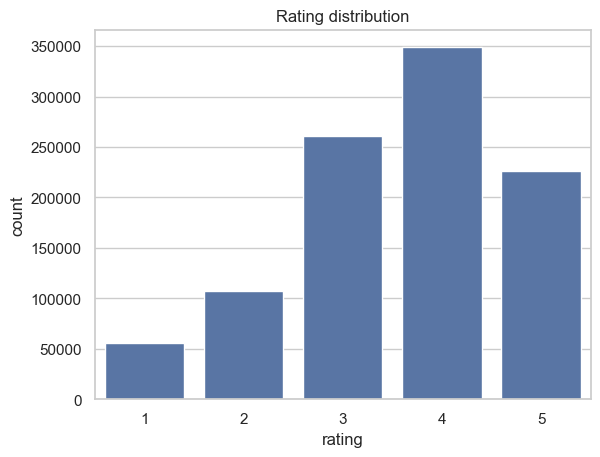

In [7]:
sns.countplot(data=ratings, x="rating")
plt.savefig(os.path.join(FIGURES, "eda_rating_distribution.png"))
plt.title("Rating distribution")
plt.show()

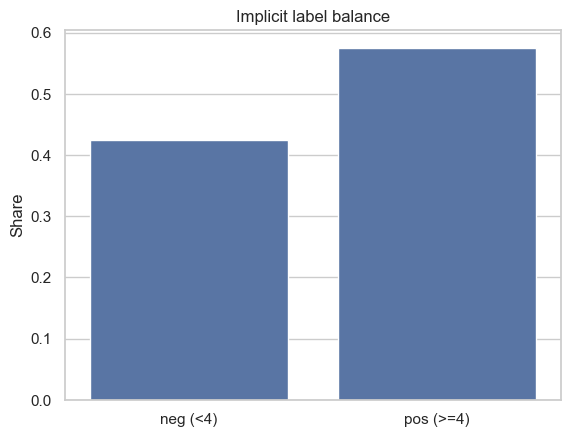

In [8]:
sns.barplot(x=["neg (<4)", "pos (>=4)"],
            y=[(ratings["interaction"]==0).mean(), (ratings["interaction"]==1).mean()])
plt.title("Implicit label balance")
plt.ylabel("Share")
plt.savefig(os.path.join(FIGURES, "eda_implicit_label_balance.png"))
plt.show()

## Users' activity and movies' popularity

### Ratings per user

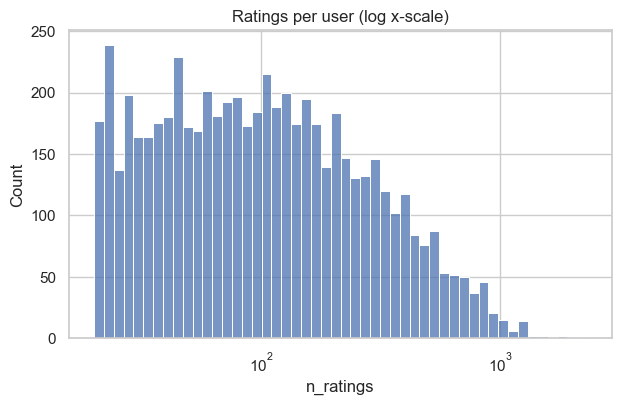

count    6040.000000
mean      165.597517
std       192.747029
min        20.000000
50%        96.000000
75%       208.000000
90%       400.000000
95%       556.000000
99%       906.660000
max      2314.000000
Name: n_ratings, dtype: float64

In [9]:
user_cnt = ratings.groupby("user_id").size().rename("n_ratings").reset_index()

plt.figure(figsize=(7,4))
sns.histplot(user_cnt["n_ratings"], bins=50, log_scale=(True, False))
plt.title("Ratings per user (log x-scale)")
plt.savefig(os.path.join(FIGURES, "eda_ratings_per_user.png"))
plt.xlabel("n_ratings")
plt.show()

user_cnt["n_ratings"].describe(percentiles=[.5,.75,.9,.95,.99])

### Ratings per movie

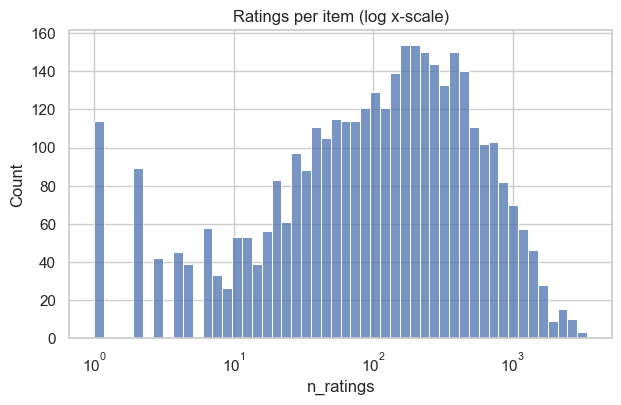

count    3706.000000
mean      269.889099
std       384.047838
min         1.000000
50%       123.500000
75%       350.000000
90%       729.500000
95%      1051.500000
99%      1784.900000
max      3428.000000
Name: n_ratings, dtype: float64

In [10]:
item_cnt = ratings.groupby("movie_id").size().rename("n_ratings").reset_index()

plt.figure(figsize=(7,4))
sns.histplot(item_cnt["n_ratings"], bins=50, log_scale=(True, False))
plt.title("Ratings per item (log x-scale)")
plt.xlabel("n_ratings")
plt.savefig(os.path.join(FIGURES, "eda_ratings_per_movie.png"))
plt.show()

item_cnt["n_ratings"].describe(percentiles=[.5,.75,.9,.95,.99])

### Top popular

/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/ipykernel_65053/4167057396.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_items, y="title", x="n_ratings", palette='tab10')


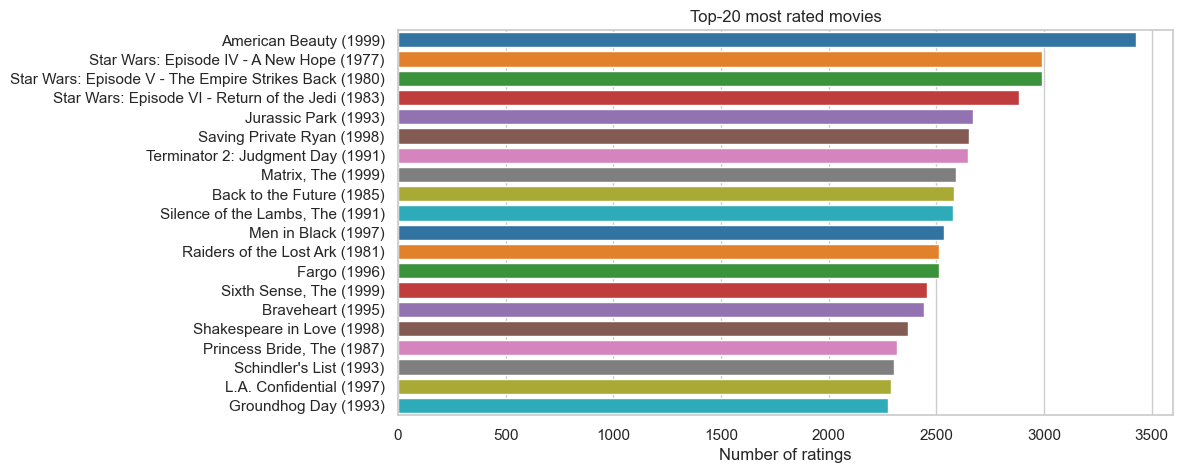

In [11]:
top_items = item_cnt.sort_values("n_ratings", ascending=False).head(20)
top_items = top_items.merge(movies_df, on="movie_id", how="left")

plt.figure(figsize=(10,5))
sns.barplot(data=top_items, y="title", x="n_ratings", palette='tab10')
plt.title("Top-20 most rated movies")
plt.xlabel("Number of ratings")
plt.ylabel("")
plt.savefig(os.path.join(FIGURES, "eda_top_20_most_rated.png"))
plt.show()

## Time dynamics

### Number of rates for time

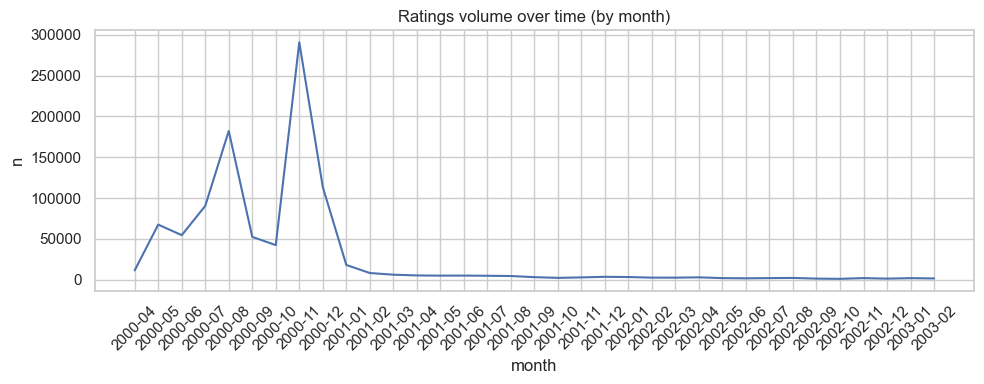

In [12]:
by_month = ratings.groupby("month").size().rename("n").reset_index()

plt.figure(figsize=(10,4))
sns.lineplot(data=by_month, x="month", y="n")
plt.title("Ratings volume over time (by month)")
plt.savefig(os.path.join(FIGURES, "eda_ratings_volume_over_time_by_month.png"))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Mean rating change

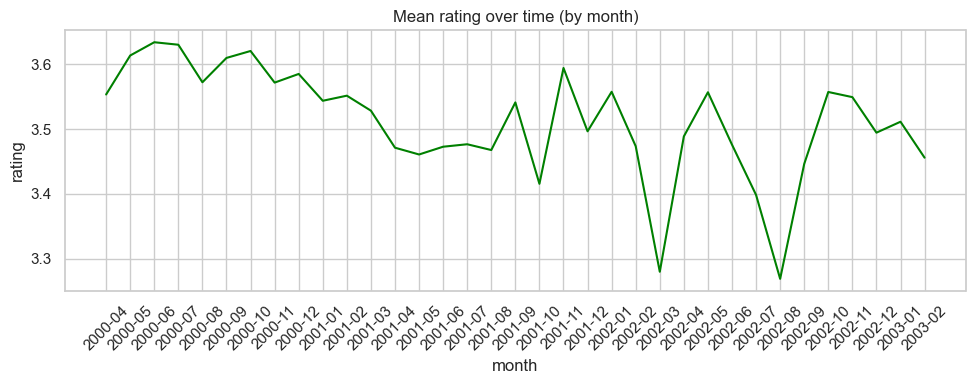

In [13]:
mean_by_month = ratings.groupby("month")["rating"].mean().reset_index()

plt.figure(figsize=(10,4))
sns.lineplot(data=mean_by_month, x="month", y="rating", color='green')
plt.title("Mean rating over time (by month)")
plt.xticks(rotation=45)
plt.savefig(os.path.join(FIGURES, "eda_mean_rating_over_time_by_month.png"))
plt.tight_layout()
plt.show()

## Genres

/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/ipykernel_65053/147855680.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=g_count, y="genre", x="n_movies", palette='deep')


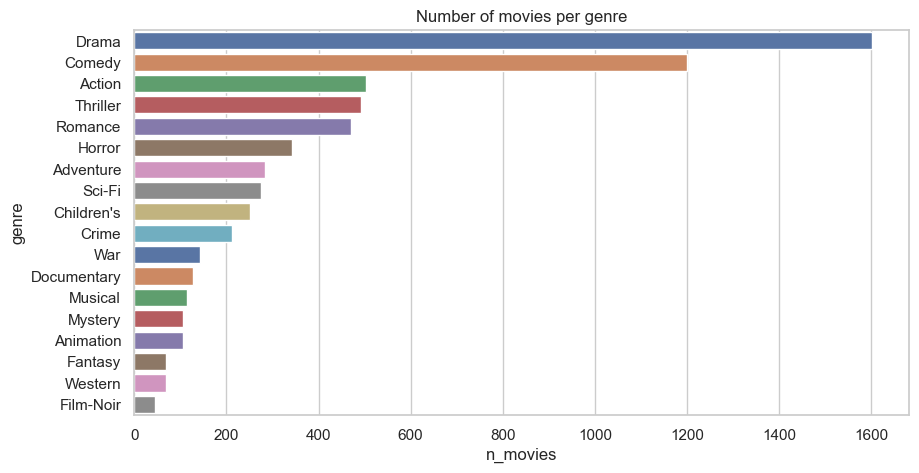

In [15]:
genres = movies_df.assign(genre=movies_df["genres"].str.split("|")).explode("genre")

g_count = genres["genre"].value_counts().reset_index()
g_count.columns = ["genre", "n_movies"]

plt.figure(figsize=(10,5))
sns.barplot(data=g_count, y="genre", x="n_movies", palette='deep')
plt.title("Number of movies per genre")
plt.savefig(os.path.join(FIGURES, "eda_number_of_movies_per_genre.png"))
plt.show()

/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/ipykernel_65053/3715780630.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=g_ratings, y="genre", x="n_ratings", palette='pastel')


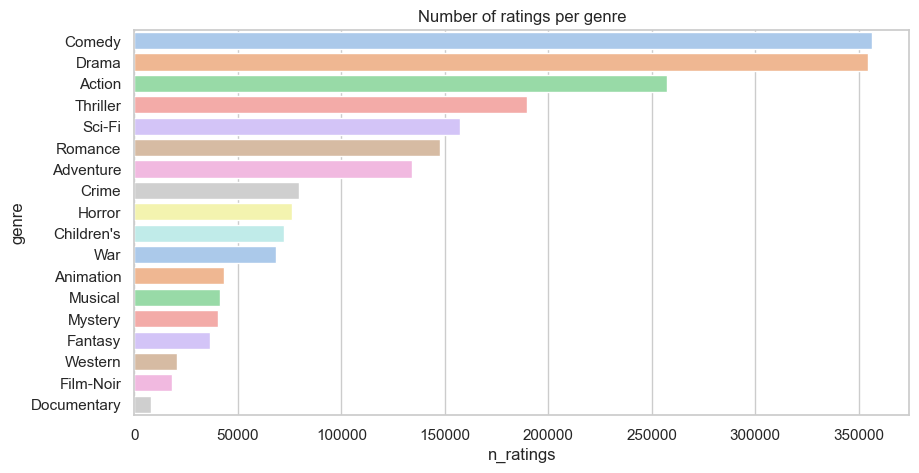

In [16]:
rm_gen = rm.merge(genres[["movie_id","genre"]], on="movie_id", how="left")
g_ratings = rm_gen.groupby("genre").size().rename("n_ratings").reset_index().sort_values("n_ratings", ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(data=g_ratings, y="genre", x="n_ratings", palette='pastel')
plt.title("Number of ratings per genre")
plt.savefig(os.path.join(FIGURES, "eda_number_of_ratings_per_genre.png"))
plt.show()

/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/ipykernel_65053/2872425844.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=g_mean, y="genre", x="rating", palette='tab10')


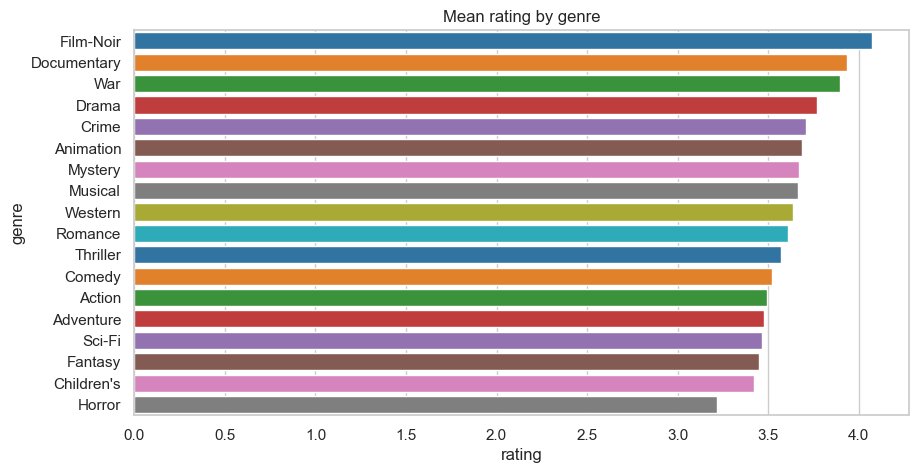

In [17]:
g_mean = rm_gen.groupby("genre")["rating"].mean().reset_index().sort_values("rating", ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(data=g_mean, y="genre", x="rating", palette='tab10')
plt.title("Mean rating by genre")
plt.savefig(os.path.join(FIGURES, "eda_mean_rating_by_genre.png"))
plt.show()

## Users' segments

/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/ipykernel_65053/3776552863.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=users_df, x="gender", palette='viridis')


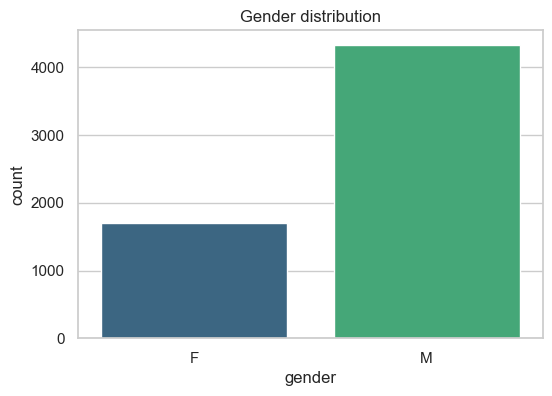

In [21]:
plt.figure(figsize=(6,4))
sns.countplot(data=users_df, x="gender", palette='viridis')
plt.title("Gender distribution")
plt.savefig(os.path.join(FIGURES, "eda_gender_distribution.png"))
plt.show()

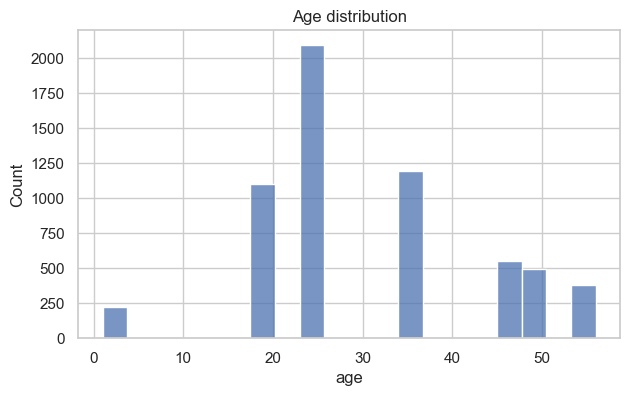

In [22]:
plt.figure(figsize=(7,4))
sns.histplot(data=users_df, x="age", bins=20)
plt.title("Age distribution")
plt.savefig(os.path.join(FIGURES, "eda_age_distribution.png"))
plt.show()

/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/ipykernel_65053/4141434925.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=gender_mean, x="gender", y="rating", palette='Set2')


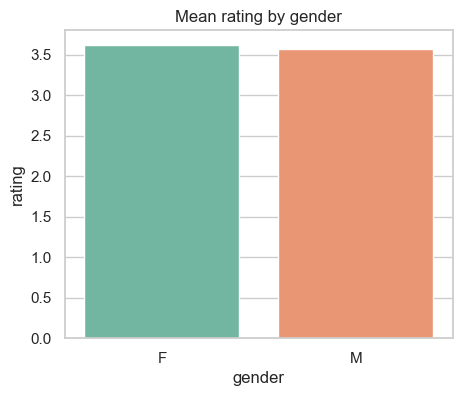

In [24]:
gender_mean = rmu.groupby("gender")["rating"].mean().reset_index()
plt.figure(figsize=(5,4))
sns.barplot(data=gender_mean, x="gender", y="rating", palette='Set2')
plt.title("Mean rating by gender")
plt.savefig(os.path.join(FIGURES, "eda_mean_rating_by_genre.png"))
plt.show()

/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/ipykernel_65053/1046146097.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=gender_cnt, x="gender", y="n_ratings", palette='mako')


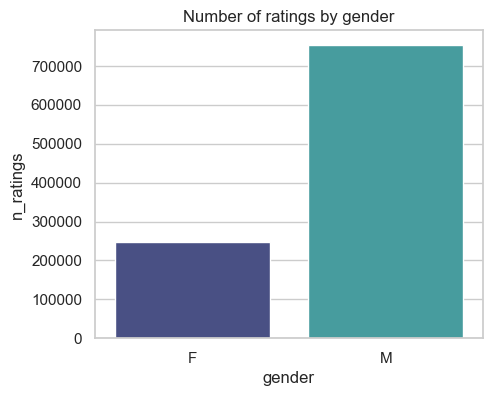

In [26]:
gender_cnt = rmu.groupby("gender").size().rename("n_ratings").reset_index()
plt.figure(figsize=(5,4))
sns.barplot(data=gender_cnt, x="gender", y="n_ratings", palette='mako')
plt.title("Number of ratings by gender")
plt.savefig(os.path.join(FIGURES, "eda_number_of_ratings_by_gender.png"))
plt.show()

## Users' interactions

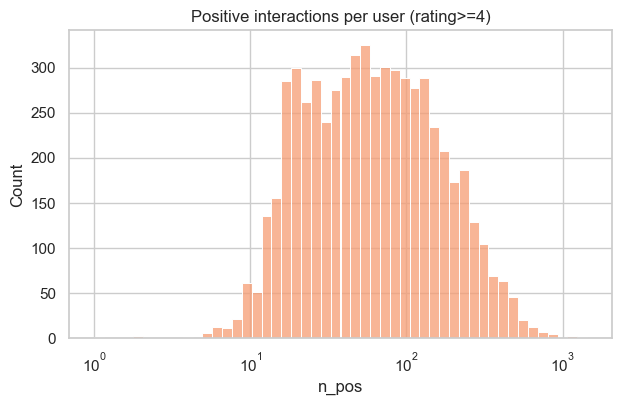

Users with <10 positives: 0.01457436237164624
Users with <20 positives: 0.14210003312355085


In [27]:
pos_cnt = ratings[ratings["interaction"]==1].groupby("user_id").size().rename("n_pos").reset_index()

plt.figure(figsize=(7,4))
sns.histplot(pos_cnt["n_pos"], bins=50, log_scale=(True, False), color=sns.color_palette("rocket", 4)[3])
plt.title("Positive interactions per user (rating>=4)")
plt.xlabel("n_pos")
plt.savefig(os.path.join(FIGURES, "eda_positive_interactions_per_user.png"))
plt.show()

print("Users with <10 positives:", (pos_cnt["n_pos"] < 10).mean())
print("Users with <20 positives:", (pos_cnt["n_pos"] < 20).mean())